Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   phy_fitness    diet_pref       act_level  sleep_hrs  mindfulness  \
0          3.0        Vegan       Sedentary          7           10   
1          4.0        Vegan  Lightly Active          7            1   
2          8.0   Vegetarian          Active          8           10   
3          2.0  Pescatarian       Sedentary          8            7   
4          9.0  Pescatarian   Highly Active          5            7   

       career  gender  daily_avg_steps  daily_avg_calories  is_healthy  
0      Artist     1.0           2020.0              1831.0           0  
1     Teacher     0.0           5154.0              2190.0           0  
2  Freelancer     1.0          12363.0              2297.0           1  
3      Doctor     0.0           1664.0              1943.0           0  
4    Business     0.0          17680.0              3527.0           1  
<class

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:58:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 XGBoost Accuracy: 0.9891666666666666
 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       803
           1       0.99      0.98      0.98       397

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


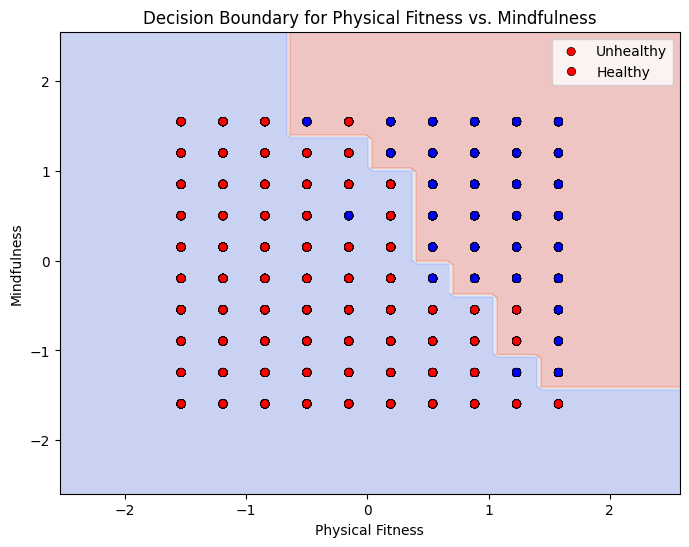

 Accuracy (Only for Phy_Fitness & Mindfulness): 0.9216666666666666


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

df = pd.read_csv('/content/drive/MyDrive/13thfebaiml/innovize_final_ml.csv')

# print(df.head())
# print(df.info())

label_encoders = {}
binary_features = ['diet_pref', 'act_level', 'gender']
for col in binary_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# One-Hot Encoding for 'career'
df = pd.get_dummies(df, columns=['career'], drop_first=True)

# Feature Selection
X = df.drop(columns=['is_healthy'])
y = df['is_healthy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
numeric_features = ['phy_fitness', 'mindfulness', 'sleep_hrs', 'daily_avg_steps', 'daily_avg_calories']
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=500, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# Train XGBoost Model
xgb_model = XGBClassifier(n_estimators=500, learning_rate=0.05, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print(" XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(" Classification Report:\n", classification_report(y_test, y_pred_xgb))

# DECISION BOUNDARY VISUALIZATION FOR `phy_fitness` & `mindfulness`
X_plot = X_train[['phy_fitness', 'mindfulness']]
y_plot = y_train

vis_model = RandomForestClassifier(n_estimators=100, random_state=42)
vis_model.fit(X_plot, y_plot)

x_min, x_max = X_plot['phy_fitness'].min() - 1, X_plot['phy_fitness'].max() + 1
y_min, y_max = X_plot['mindfulness'].min() - 1, X_plot['mindfulness'].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

Z = vis_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
sns.scatterplot(x=X_plot['phy_fitness'], y=X_plot['mindfulness'], hue=y_plot, palette={0: 'red', 1: 'blue'}, edgecolor='black')

plt.xlabel("Physical Fitness")
plt.ylabel("Mindfulness")
plt.title("Decision Boundary for Physical Fitness vs. Mindfulness")
plt.legend(["Unhealthy", "Healthy"])
plt.show()

y_pred_plot = vis_model.predict(X_test[['phy_fitness', 'mindfulness']])
accuracy_plot = accuracy_score(y_test, y_pred_plot)
print(" Accuracy (Only for Phy_Fitness & Mindfulness):", accuracy_plot)
